<a href="https://colab.research.google.com/github/lucasflores/PermaLost/blob/main/PermaFrostProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Permafrost Project

## The Problem

Melt and thaw of ground leads to decay of 'soft' artifacts -> race to save these from decay/rot

## The Project

In this project I will use permafrost data provided by the European Space Agency's (ESA) Climate Change Initiative (CCI) Permafrost project.  It is derived from a thermal model driven and constrained by satellite data.

## The Data
Permafrost is an Essential Climate Variable (ECV) within the Global Climate Observing System (GCOS), which is characterized by subsurface temperatures and the depth of the seasonal thaw layer. Complementing ground-based monitoring networks, the Permafrost CCI project is establishing Earth Observation (EO) based products for the permafrost ECV spanning the last two decades. Since ground temperature and thaw depth cannot be directly observed from space-borne sensors, a variety of satellite and reanalysis data are combined in a ground thermal model. The algorithm uses remotely sensed data sets of Land Surface Temperature (MODIS LST/ ESA LST CCI) and landcover (ESA Landcover CCI) to drive the transient permafrost model CryoGrid CCI, which yields thaw depth and ground temperature at various depths, while ground temperature forms the basis for permafrost fraction.

### Temporal compositing
Grid products of CDRP v1 are released in annual files, covering the start to the end of the Julian year. This corresponds to average annual ground temperatures, as well as the maximum depth of seasonal thaw, which corresponds to the active layer thickness.
### Spatial resolution
The spatial resolution of the grid product is 926.63 m. Grid attributes are computed in each cell of that size within the time period indicated above. The spatial resolution is limited by the spatial resolution of
remotely sensed Landsurface Temperature.
### Product projection system
The Coordinate Reference System (CRS) used for CRDPv1 is Polar Stereographic projection (Arctic) based on the World Geodetic System 84 (WGS84) reference ellipsoid. The coordinates are specified in meters. It covers the northern hemisphere, extending down to 35 °N latitude in the North America and down to 25 °N in Asia

### **GTD** Ground temp (by depth) - **GST**, **T1m**, **T2m**, **T5m**, and **T10m**
This corresponds to average annual ground temperatures and is provided for specific depths,
Ground Surface Temperature, 1 meter beneath surface, 2 meters beneath surface, 5 meters beneath surface, and 10 meters beneath surface.

### **PFR** Permafrost extent (fraction)
The boundary of permafrost can be defined as
1. The geographical boundary between the continuous and discontinuous permafrost zones.
2. The margin of a discrete body of permafrost.

A permafrost region is commonly subdivided into permafrost zones based on the proportion of the ground that is perennially cryotic. The basic subdivision in high latitudes is into zones of continuous permafrost and discontinuous permafrost. REFERENCES: Muller, 1943; Brown, 1967, 1978; Washburn, 1979; Pewe, 1983. Continuous permafrost is the major subdivision of a permafrost region in which permafrost occurs everywhere beneath the exposed land surface with the exception of widely scattered sites. Taliks associated with rivers and lakes may occur in the continuous permafrost zone. REFERENCE: Brown, 1970. Discontinuous permafrost corresponds to permafrost occurring in some areas beneath the exposed land
surface throughout a geographic region where other areas are free of permafrost. Discontinuous permafrost occurs between the continuous permafrost zone and the southern latitudinal limit of permafrost in lowlands. Depending on the scale of mapping, several subzones can often be
distinguished, based on the percentage (or fraction) of the land surface underlain by permafrost, as shown in the following table.

### **ALT** Active Layer Thickness
Active Layer Thickness is the thickness of the layer of the ground that is subject to annual thawing and freezing in areas underlain by permafrost. The thickness of the active layer depends on such factors as the ambient air temperature, vegetation, drainage, soil or rock type and total water content, snowcover, and degree and orientation of slope. As a rule, the active layer is thin in the High Arctic (it can be less than 15 cm) and becomes thicker farther south (1 m or more).
The thickness of the active layer can vary from year to year, primarily due to variations in the mean annual air temperature, distribution of soil moisture, and snowcover





### Project Package Dependencies  
- pandas 
- geopandas 
- matplotlib
- sklearn
- skforecast

### ML/Analysis algorithm note
* Geographic Weighted Regression seems to be a reasonable start for some predictive analysis via the mgwr python package (more details here https://deepnote.com/@carlos-mendez/PYTHON-GWR-and-MGWR-cd2LqaPqTSibIEHMiigreg)
* Might just be useful for interpolation. Not sure if I can do like a time series regression. 
* gwr/mgwr has a “bandwidth“ parameter which sets the “neighborhood” size to be used for the location based regression. Also it seems to apply some shooting which I should read up more on.  

## General Notes
### *04/05/22* 
* Data downloading, combing of separate PFR, ATL, and GTD files, and deleting nan and non Greenland data in dfs (most expensive/longest steps) takes about 1-1.5 hours.
* Downloads faster on google cola but not enough RAM to do row dropping computations. Trying to find smart ways to release RAM. Should check in indices of “”Greenland” lat/longs exist in some relatively close range that I can take advantage of so I don’t have to loop through every goddamn instance. 
* Want to implement a memory profiler as well. 

### *09/08/22*
* Basics time series regression set up
* Need to compare a few more models
* Need to do a bigger study on a hyperparameter grid search
* Need to develop vulnerability metric(s)
* Need to understand parameters I am getting out from the forecaster object. i.e. lag coefficients. 


In [1]:
!pip install matplotlib --upgrade
!pip install --upgrade geopandas
!pip install folium matplotlib mapclassify
!pip3 install pickle5
!pip install wget
!pip install skforecast
#!pip install dtale

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pandas as pd
import sklearn
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle5 as pickle
import geopandas as gpd
from shapely.geometry import Point
import folium
import wget
import xarray as xr
import gc   #garbage collector interface

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import metrics

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from time import time
from joblib import dump, load
#import dtale
#import dtale.global_state as global_state
#global_state.set_chart_settings({'scatter_points': 15000, '3d_points': 40000})
#import dtale.app as dtale_app
#dtale_app.USE_COLAB = True

# Get The Data

In [ ]:
 # mount google drive area 
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# returns df containing data with in the rectanular Lat/Long area specified
def selectRectangularArea(dataPath, dataName, botLat, topLat, leftLong, rightLong) :
  wget.download(dataPath, './')
  ds = xr.open_dataset(dataName)
  os.remove(dataName)
  df = ds.to_dataframe() #RAM destroyer
  del ds    # No longer need dataset
  %reset -f Out   # Release memory
  gc.collect() # Collect memory garbage
  df = df.reset_index()
  df = df.iloc[leftLong:rightLong] 
  %reset -f Out
  gc.collect() 
  df.drop(df[df['y'] < botLat].index, inplace=True)
  df.drop(df[df['y'] > topLat].index, inplace=True)
  %reset -f Out
  gc.collect()

  return df

# returns single geoDataframe with all years 
def buildDataset(years, picklesExist):
  if not picklesExist :
    for year in years :
      if int(year) >= 2003 :
        dataset_name_ALT = "ESACCI-PERMAFROST-L4-ALT-MODISLST_CRYOGRID-AREA4_PP-"+year+"-fv03.0.nc"
        dataset_name_PFR = "ESACCI-PERMAFROST-L4-PFR-MODISLST_CRYOGRID-AREA4_PP-"+year+"-fv03.0.nc"
        dataset_name_GTD = "ESACCI-PERMAFROST-L4-GTD-MODISLST_CRYOGRID-AREA4_PP-"+year+"-fv03.0.nc"
      else :
        dataset_name_ALT = "ESACCI-PERMAFROST-L4-ALT-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-"+year+"-fv03.0.nc"
        dataset_name_PFR = "ESACCI-PERMAFROST-L4-PFR-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-"+year+"-fv03.0.nc"
        dataset_name_GTD = "ESACCI-PERMAFROST-L4-GTD-ERA5_MODISLST_BIASCORRECTED-AREA4_PP-"+year+"-fv03.0.nc"
      ALT = "https://dap.ceda.ac.uk/neodc/esacci/permafrost/data/active_layer_thickness/L4/area4/pp/v03.0//"+dataset_name_ALT
      PFR = "https://dap.ceda.ac.uk/neodc/esacci/permafrost/data/permafrost_extent/L4/area4/pp/v03.0//"+dataset_name_PFR
      GTD = "https://dap.ceda.ac.uk/neodc/esacci/permafrost/data/ground_temperature/L4/area4/pp/v03.0//"+dataset_name_GTD

      # Restrict to Lat/Long containing Greenland only
      dfPFR = selectRectangularArea(PFR, dataset_name_PFR, -2900000.0, -420000.0, 40361213, 65095962) # x: -2.499489e+06 to -2.857811e+05
      dfALT = selectRectangularArea(ALT, dataset_name_ALT, -2900000.0, -420000.0, 40361213, 65095962) 

      dfGreenland_PFR_ALT = pd.concat([dfPFR, dfALT['ALT']], axis=1)
      del dfPFR
      del dfALT
      #del dfGTD
      dfGreenland_PFR_ALT = dfGreenland_PFR_ALT.dropna(subset=['PFR','ALT'], how='all')
      #dfGTD = dfGTD.dropna(subset=['GST','T1m','T2m','T5m','T10m'], how='all')
      dfGreenland_PFR_ALT.to_pickle("/content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/Greenland_PFR_ALT_noNANallColumns_"+year+"_Pickle.pkl")
      #dfGTD.to_pickle("Greenland_GTD_noNANallColumns_"+year+"_Pickle.pkl")
      del dfGreenland_PFR_ALT
      %reset -f Out
      gc.collect() 
      #gdfGreenland = gpd.GeoDataFrame( dfGreenland, geometry=gpd.points_from_xy(dfGreenland.x, dfGreenland.y))

  dfGreenland_dict = {}
  for year in years :
    with open('/content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/Greenland_PFR_ALT_noNANallColumns_'+year+'_Pickle.pkl', 'rb') as pickle_file:
      dfGreenland_dict[year] = pickle.load(pickle_file)
  # Convert DataFrame to a geoDataFrame
  gdfGreenland_dict = {}
  for year in years :
    gdfGreenland_dict[year] = gpd.GeoDataFrame(dfGreenland_dict[year], geometry=gpd.points_from_xy(dfGreenland_dict[year].x, dfGreenland_dict[year].y))
  del dfGreenland_dict
  %reset -f Out
  gc.collect()
  
  gdfGreenland = pd.DataFrame()
  for year in years : 
    gdfGreenland = pd.concat([gdfGreenland, gdfGreenland_dict[year]])
  #gdfGreenland = pd.concat([gdfGreenland_dict['1997'], gdfGreenland_dict['1998'], gdfGreenland_dict['1999'], gdfGreenland_dict['2000'], gdfGreenland_dict['2001'], gdfGreenland_dict['2002'], gdfGreenland_dict['2003'], gdfGreenland_dict['2004'], gdfGreenland_dict['2005']], axis=0)
  del gdfGreenland_dict
  %reset -f Out
  gc.collect()

  #gdfGreenland.to_pickle("/content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/gdfGreenland_Pickle.pkl")

  return gdfGreenland 



In [4]:
def doAnalysis(dataset, alg) :
  point_train = dataset[0:6] 
  point_test = dataset[6:9]
  pipe = Pipeline([
     ('regressor', alg)
  ])
  forecaster = ForecasterAutoreg(
               regressor = pipe,
               lags = 3
  )
  t0 = time()
  forecaster.fit(y=point_train['ALT'])
  train_time = time() - t0

  t0 = time()
  predictions = forecaster.predict(steps=3)
  test_time = time() - t0
  score = sklearn.metrics.mean_squared_error(point_test['ALT'], predictions)
  alg_name = str(alg).strip('()')
  return score, train_time, test_time, alg_name


In [5]:
# Produces a bar graph with the output metrics, can compare models and/or data inputs here
def buildMetaAlgPlots(datasets, algs) :
    results = []
    for alg in algs :
      score_avg = 0.0
      for dataset in datasets :
        score, train_time, test_time, alg_name = doAnalysis(dataset, alg)
        score_avg = score_avg + score
      score_avg = score_avg/len(datasets)
      results.append([score_avg, train_time, test_time, alg_name])
    
    score_lst = [row[0] for row in results]
    train_time_lst = [row[1] for row in results]
    test_time_lst = [row[2] for row in results]
    alg_name_lst = [row[3] for row in results]
    biny = np.arange(len(results))

    fig, ax = plt.subplots(figsize=(12,8))
    hbars = ax.barh(biny, score_lst, 0.2, label="score", align='center')
    hbars_tr = ax.barh(biny+0.3, train_time_lst, 0.2, label="training time", align='center')
    hbars_tes = ax.barh(biny+0.6, test_time_lst, 0.2, label="test time", align='center')
    ax.set_yticks(biny+0.3, labels=alg_name_lst)
    ax.bar_label(hbars, fmt='%.4f', padding=8, fontsize=12)
    ax.bar_label(hbars_tr, fmt='%.4f s', padding=8, fontsize=12)
    ax.bar_label(hbars_tes, fmt='%.4f s' , padding=8, fontsize=12)
    ax.invert_yaxis() 
    ax.set_xlabel("Accuracy Score / Time (s)")
    ax.set_title("")
    plt.xlim([0.,0.9])
    plt.style.use('dark_background')
    plt.legend(loc="best")
    plt.show()

In [6]:
# dataset years to download. years 1997 t0 2018 currently available
#years = ['1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
#gdfGreenland = buildDataset(years, picklesExist=True)
#%ls /content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/
with open('/content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/gdfGreenland_AllYears.pkl', 'rb') as pickle_file:
  gdfGreenland = pickle.load(pickle_file)

In [ ]:
#gdfGreenland.to_pickle("/content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/gdfGreenland_AllYears.pkl")

In [7]:
InputLat = -2000000.
InputLong = -500000.

def genGridOfNine(gdfGreenland, Lat, Long) :
  deltaNN = 927.

  nearestLat = min(gdfGreenland['x'], key=lambda x:abs(x-Lat))
  nearestLong = min(gdfGreenland['y'], key=lambda x:abs(x-Long))

  NNLatUp = min(gdfGreenland['x'], key=lambda x:abs(x-Lat+deltaNN))
  NNLongRight = min(gdfGreenland['y'], key=lambda x:abs(x-Long+deltaNN))
  NNLatDown = min(gdfGreenland['x'], key=lambda x:abs(x-Lat-deltaNN))
  NNLongLeft = min(gdfGreenland['y'], key=lambda x:abs(x-Long-deltaNN))

  GridNNnieghbors = [[nearestLat, nearestLong], [nearestLat, NNLongRight],[nearestLat, NNLongLeft],[NNLatUp, NNLongLeft],[NNLatUp,nearestLong],[NNLatUp,NNLongRight],[NNLatDown, NNLongLeft],[NNLatDown, nearestLong],[NNLatDown,NNLongRight]]
  # maps out a grid of nearest neighbors
  #
  #        *  *  *
  #        *  @  *
  #        *  *  *
  # 
  # need to check if we are at an edge 
  pointsOfInterest = []
  for point in GridNNnieghbors :
    pointOfInterest = gdfGreenland[(gdfGreenland['x'] == point[0]) & (gdfGreenland['y'] == point[1])]
    pointOfInterest['time'] = pd.to_datetime(pointOfInterest['time'], format='%Y')
    pointOfInterest = pointOfInterest.set_index('time')
    pointOfInterest = pointOfInterest.asfreq('AS')
    pointsOfInterest.append(pointOfInterest)
  
  return pointsOfInterest


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

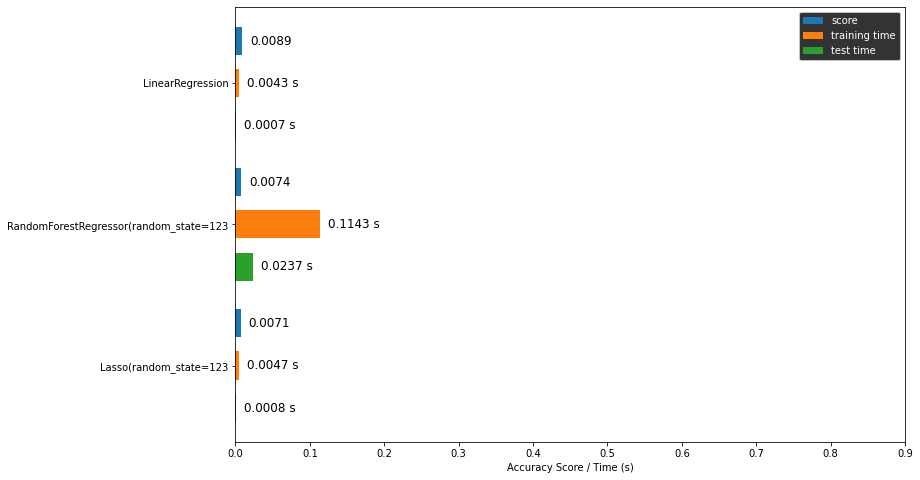

In [8]:
pointsOfInterest = genGridOfNine(gdfGreenland, -2000000.,-500000.)
score, train_time, test_time, alg_name = doAnalysis(pointsOfInterest[0], LinearRegression())
buildMetaAlgPlots(pointsOfInterest, [LinearRegression(), RandomForestRegressor(random_state=123), Lasso(random_state=123)])

In [9]:
# Grid search of hyperparameters 
# ============================================== =================================== 
forecaster  =  ForecasterAutoregMultiOutput( 
    regressor  =  make_pipeline(StandardScaler(), Lasso(random_state=123)), 
    steps      =  4, 
    lags       =  3  # This value will be replaced in the grid search 
)
# To access the parameters of a scikitlearn pipeline, follow the 
# pattern: <component name>__<parameter name>. 
param_grid  =  {'lasso__alpha': np.logspace(-5 , 5, 10)} 
lags_grid  =  [2, 3, 4]

results_grid =  grid_search_forecaster( 
    forecaster = forecaster , 
    y = pointsOfInterest[0]['ALT'], 
    param_grid = param_grid, 
    lags_grid = lags_grid, 
    steps = 4,
    refit = True,
    metric = 'mean_squared_error', 
    initial_train_size = int(len(pointsOfInterest[0])*0.5), 
    fixed_train_size = False, 
    return_best = True, 
    verbose = False
)

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:02<00:00,  1.46it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'lasso__alpha': 0.2782559402207126}
  Backtesting metric: 0.006861209147588178



In [ ]:
#!pip install PyQt5
#!pip install mplcursors
#from mplcursors import cursor  # separate package must be installed

In [ ]:
#%matplotlib qt

In [10]:
def plotForecastAndPredInterval(point, alg) :
  point_train = point[0:14] 
  point_test = point[14:23]
  fig, ax = plt.subplots(figsize=(9, 4)) 
  point_train['ALT'].plot(ax=ax, label='train') 
  point_test['ALT'].plot(ax=ax, label='test') 
  pipe = Pipeline([
      ('regressor', alg)
  ])
  forecaster = ForecasterAutoreg(
                regressor = pipe,
                lags = 4
  )
  forecaster.fit(y=point_train['ALT'])
  predictions = forecaster.predict_interval( 
                    steps     =  12, 
                    interval  =  [1,  99], 
                    n_boot    =  500 
               )
  #print(forecaster.get_coef())
  predictions.plot(ax=ax, label='predictions') 
  ax.fill_between ( 
    predictions.index , 
    predictions['lower_bound'], 
    predictions['upper_bound'], 
    color = 'red', 
    alpha = 0.2) 
  ax.legend()

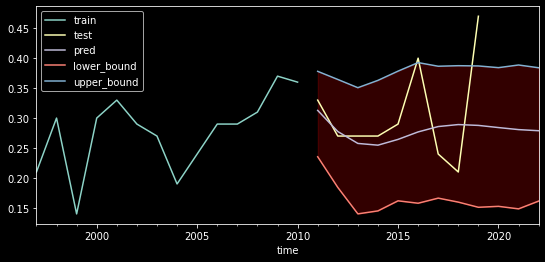

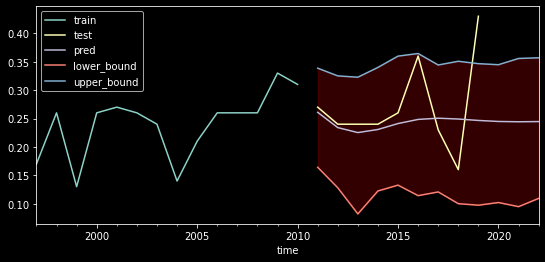

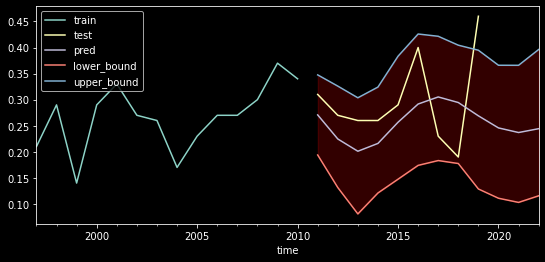

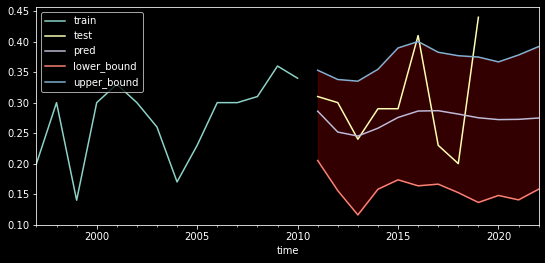

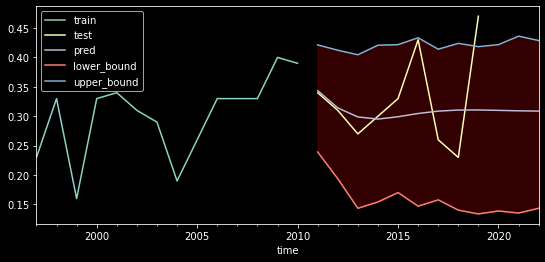

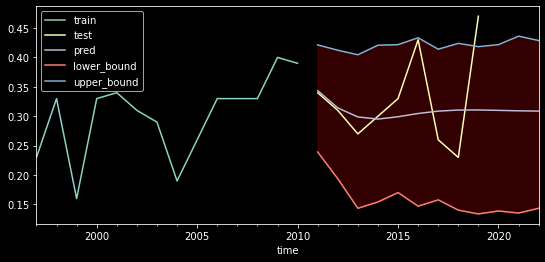

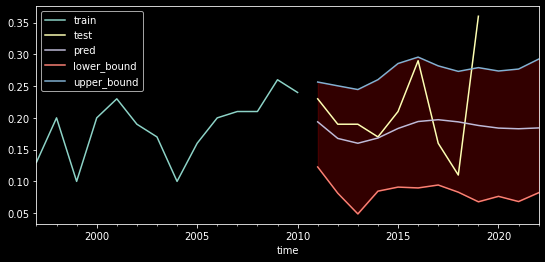

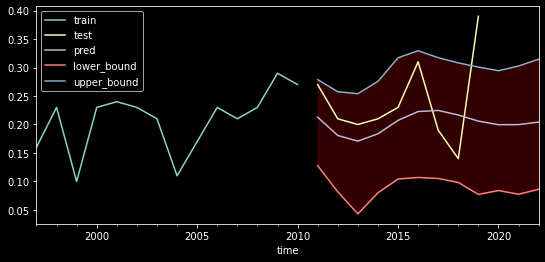

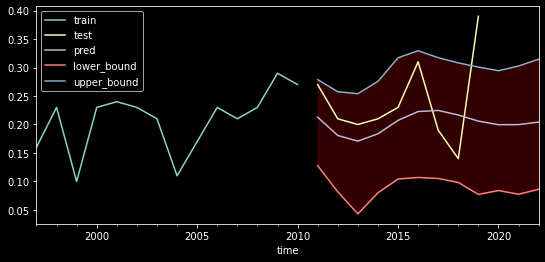

In [11]:
for point in pointsOfInterest :
  plotForecastAndPredInterval(point, LinearRegression())

In [12]:
# Developing "vulnerability" metric here
# Could do something like the frequency of ALT dipping below the depth of interest 
def vulnerability(gdf, ground_depth, Lat, Long, year):
  pointsOfInterest = genGridOfNine(gdf, Lat, Long)
  isVuln=[]
  years = ['1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
  for year in years :
    if pointsOfInterest[0][year]['ALT'] >= ground_depth : # center point
      isVuln.append([year, float(pointsOfInterest[0][year]['ALT'])]) # number of time local has become "vulnerable" over data period 



In [ ]:
glaciers = gpd.read_file('/content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/GlacierBaseMap/jf791qw8489.shp') #2017 dataset
glaciers = glaciers[glaciers.cenlat > 59.0][glaciers.cenlat < 73.83][glaciers.cenlon > -57.5][glaciers.cenlon < -40.57]
glaciers = glaciers.to_crs("EPSG:3995") # world.to_crs(epsg=3395) would also work

coastlines = gpd.read_file('/content/drive/MyDrive/ColabNotebooks/PermaFrostProjData/CoastLineBaseMap/sd368wz2435.shp')
coastlines = coastlines.to_crs("EPSG:3995") # world.to_crs(epsg=3395) would also work

gc.collect()

gdfGreenland.crs = "EPSG:3995"

#buffer = gdfGreenland.buffer((926.63)/2, cap_style=3)
#gdfGreenland = gdfGreenland.drop(columns=['geometry'])
#gdfGreenland['geometry'] = buffer

In [ ]:
def mapWithFeature(gdf, coastlines, glaciers, year, leftLong, rightLong, botLat, topLat):
  gdf = gdfGreenland[(gdfGreenland['time'] == str(year)+'-01-01') & (gdfGreenland['y'] >= (botLat-0.1e6)) & (gdfGreenland['y'] <= topLat) & (gdfGreenland['x'] >= (leftLong-1.3e6)) & (gdfGreenland['x'] <= (rightLong+0.1e6))]
  center = gdf.unary_union.centroid
  coastlines_rot = coastlines.rotate(30, origin=center)
  coastlines = coastlines.drop(columns=['geometry'])
  coastlines['geometry'] = coastlines_rot
  ax = coastlines.boundary.plot(figsize=(21,14), color='white', alpha=0.9, zorder=0)
  ax.set_title("Greenland")
  ax.set_ylim([botLat, topLat])
  ax.set_xlim([leftLong, rightLong])
  
  gdfRotated = gdf.rotate(30, origin=center)
  gdf = gdf.drop(columns=['geometry'])
  gdf['geometry'] = gdfRotated
  gdf.plot(ax=ax, column="ALT", cmap="plasma", markersize=0.06, legend=True, alpha=0.7, zorder=500)
  glaciers_rot = glaciers.rotate(30, origin=center)
  glaciers = glaciers.drop(columns=['geometry'])
  glaciers['geometry'] = coastlines_rot
  glaciers.plot(ax=ax,color='white', alpha=0.7, zorder=0)
  #plt.style.use('dark_background')
  plt.show()

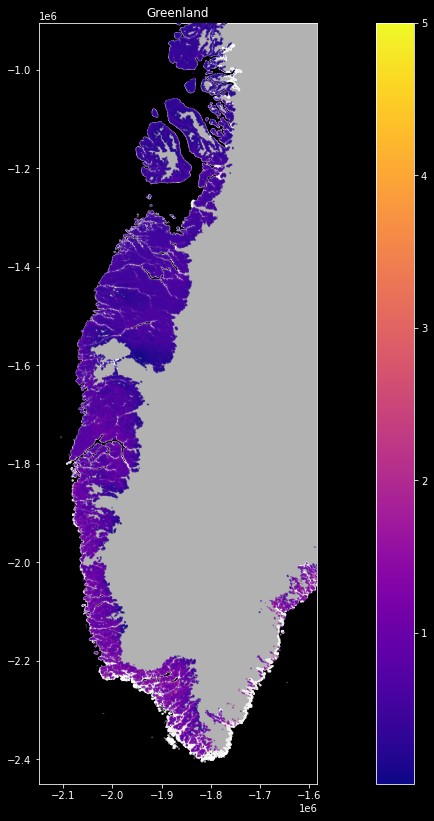

In [ ]:
mapWithFeature(gdfGreenland, coastlines, glaciers, 2000, -2.15e6, -1.584e6, -2.45e6, -0.905e6)

In [ ]:
#def IsItMelty(Year, Lat, Long) :

In [ ]:
'''
pointsOfInterest = []
gdfGreenland_smol = gdfGreenland[gdfGreenland['time'] == '1997-01-01 00:00:00']
for index, point in gdfGreenland_smol.iterrows() :
  pointOfInterest = gdfGreenland[(gdfGreenland['x'] == point['x']) & (gdfGreenland['y'] == point['y'])]
  pointOfInterest['time'] = pd.to_datetime(pointOfInterest['time'], format='%Y')
  pointOfInterest = pointOfInterest.set_index('time')
  pointOfInterest = pointOfInterest.asfreq('AS')
  pointsOfInterest.append(pointOfInterest)
  print(pointsOfInterest)
'''

In [ ]:
map = folium.Map(location = [13.406,80.110], tiles = "Stamen Terrain", zoom_start = 9)
map